In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
from fracdiff.sklearn import Fracdiff
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [47]:
def sharpe(y_true, y_pred):
    pred_sign = np.sign(y_pred)
    y_true = np.squeeze(y_true)
    returns = np.where((pred_sign == 1), y_true, 0)
    returns = np.where((pred_sign == -1), y_true * -1, returns)
    return returns.mean() / returns.std()
sharpeScorer = make_scorer(sharpe, greater_is_better=True)

def create_target(df, target, name, lookforward=1):
    df[name] = np.log(df[target].shift(periods=-lookforward)/df[target])
    return df

In [48]:
tickers = ['ETH-USD','BTC-USD'] #crypto might have more alpha than stocks
df = yf.download(tickers, period='2y', interval='1h', progress=False)['Close'] #intraday data might have more alpha than daily data
# df = yf.download(ticker, period='max')

# our target will be a long ETH and short BTC portfolio, to adjust for the "market" effect
df = df.divide(df['BTC-USD'], axis=0)
df.drop('BTC-USD', axis=1, inplace=True)

target = 'ETH-USD'

lookforward = 1
df = create_target(df, target, 'Target', lookforward=lookforward)
df.dropna(inplace=True)
X = df[target]
X = X.values.reshape(-1,1) # dont use this if you have more than 1 column in X
y = df['Target']

In [49]:
tscv = TimeSeriesSplit(n_splits=2, gap=lookforward)
model = LinearRegression(fit_intercept=False)
pipe = Pipeline([
    ('fracdiff', Fracdiff()),
    ('model', model)
])
param_dist = {
    'fracdiff__d': np.arange(0.5, .99, 0.01),
    'fracdiff__window': np.arange(2, (31*24) + 1, 1),
}

In [ ]:
search = GridSearchCV(pipe, param_grid=param_dist, cv=tscv, scoring=sharpeScorer, n_jobs=-1, verbose=0)
search.fit(X, y)

In [51]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation sharpe: {0:.4f}".format(
                  results['mean_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(search.cv_results_)

Model with rank: 1
Mean validation sharpe: 0.0656
Parameters: {'fracdiff__d': 0.9500000000000004, 'fracdiff__window': 554}

Model with rank: 1
Mean validation sharpe: 0.0656
Parameters: {'fracdiff__d': 0.9500000000000004, 'fracdiff__window': 555}

Model with rank: 1
Mean validation sharpe: 0.0656
Parameters: {'fracdiff__d': 0.9500000000000004, 'fracdiff__window': 556}

Model with rank: 1
Mean validation sharpe: 0.0656
Parameters: {'fracdiff__d': 0.9500000000000004, 'fracdiff__window': 557}

Model with rank: 5
Mean validation sharpe: 0.0656
Parameters: {'fracdiff__d': 0.9500000000000004, 'fracdiff__window': 546}

Model with rank: 5
Mean validation sharpe: 0.0656
Parameters: {'fracdiff__d': 0.9500000000000004, 'fracdiff__window': 547}

Model with rank: 5
Mean validation sharpe: 0.0656
Parameters: {'fracdiff__d': 0.9500000000000004, 'fracdiff__window': 548}

Model with rank: 5
Mean validation sharpe: 0.0656
Parameters: {'fracdiff__d': 0.9500000000000004, 'fracdiff__window': 549}



In [52]:
logX = np.log(df[target]/df[target].shift(1))
logX = logX.values.reshape(-1,1)

logReturns = cross_val_score(estimator=model, X=logX[1:], y=y[1:], scoring=sharpeScorer, cv=tscv, n_jobs=-1)
print("Log sharpe:")
print("Sharpe:", logReturns.mean())
print("")

longOnly = cross_val_score(estimator=DummyRegressor(strategy='constant', constant=1), X=X, y=y, scoring=sharpeScorer, cv=tscv, n_jobs=-1)
print("Long only sharpe:")
print("Sharpe:", longOnly.mean())
print("")

shortOnly = cross_val_score(estimator=DummyRegressor(strategy='constant', constant=-1), X=X, y=y, scoring=sharpeScorer, cv=tscv, n_jobs=-1)
print("Short only sharpe:")
print("Sharpe:", shortOnly.mean())
print("")

Log sharpe:
Sharpe: 0.062153136002391404

Long only sharpe:
Sharpe: -0.003920353106805642

Short only sharpe:
Sharpe: 0.003920353106805642



We can see the fracdiff model outperforms the log returns model, and the naive long/short models.

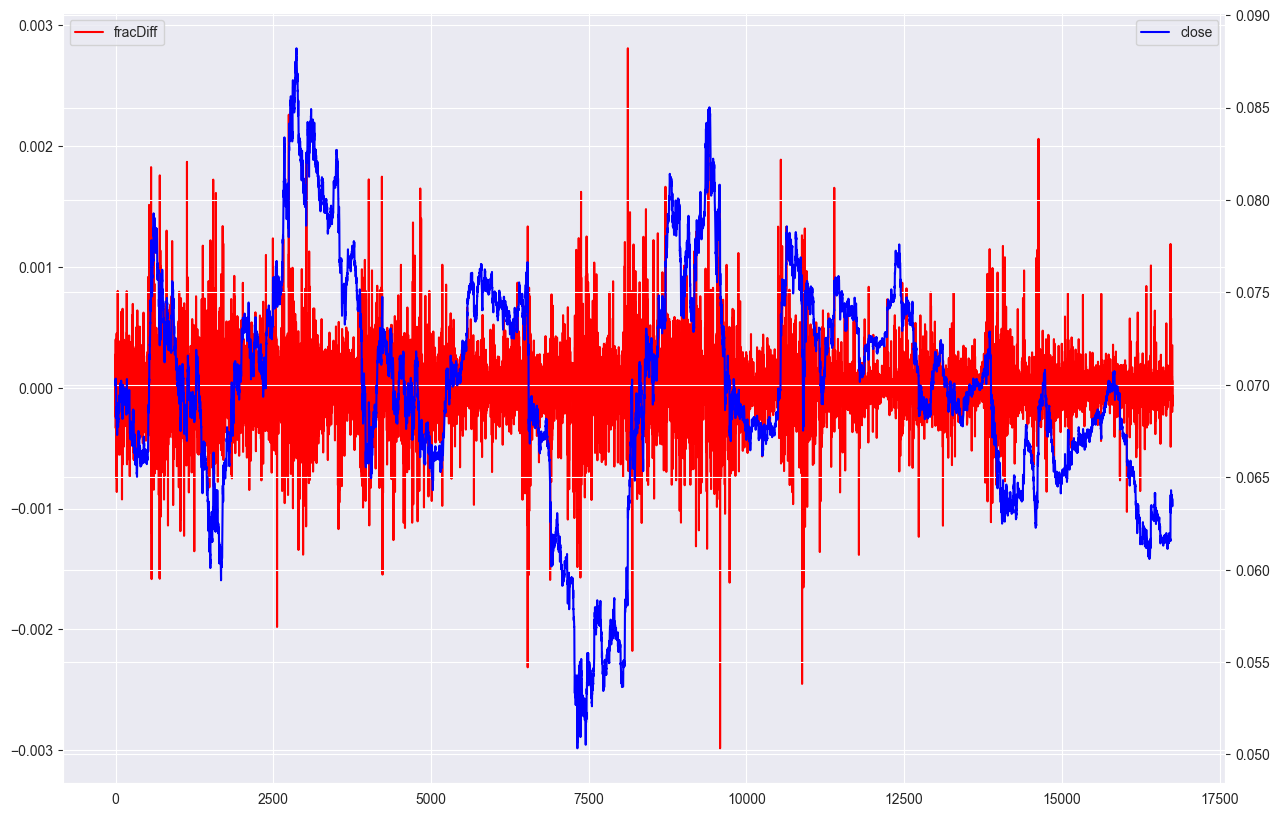

In [72]:
fracDiff = Fracdiff(d=search.best_params_['fracdiff__d'], window=search.best_params_['fracdiff__window']).fit_transform(X)
fracDiff = fracDiff[search.best_params_['fracdiff__window']:]
close = df[target].values[search.best_params_['fracdiff__window']:]

fig, ax1 = plt.subplots(figsize=(15,10))
ax1.plot(fracDiff, color='red', label='fracDiff')
ax2 = ax1.twinx()
ax2.plot(close, color='blue', label='close')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

# plt.plot(fracDiff)
# plt.show()
# plt.plot(close)
# plt.show()

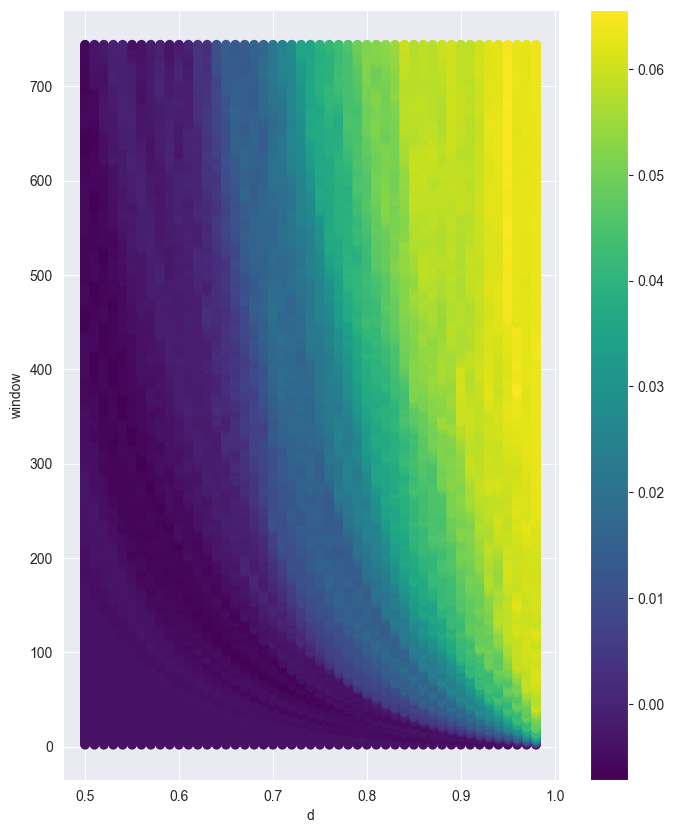

In [63]:
plt.figure(figsize=(8,10))
plt.scatter(search.cv_results_['param_fracdiff__d'], search.cv_results_['param_fracdiff__window'], c=search.cv_results_['mean_test_score'], cmap='viridis')
plt.colorbar()
plt.xlabel('d')
plt.ylabel('window')
plt.show()

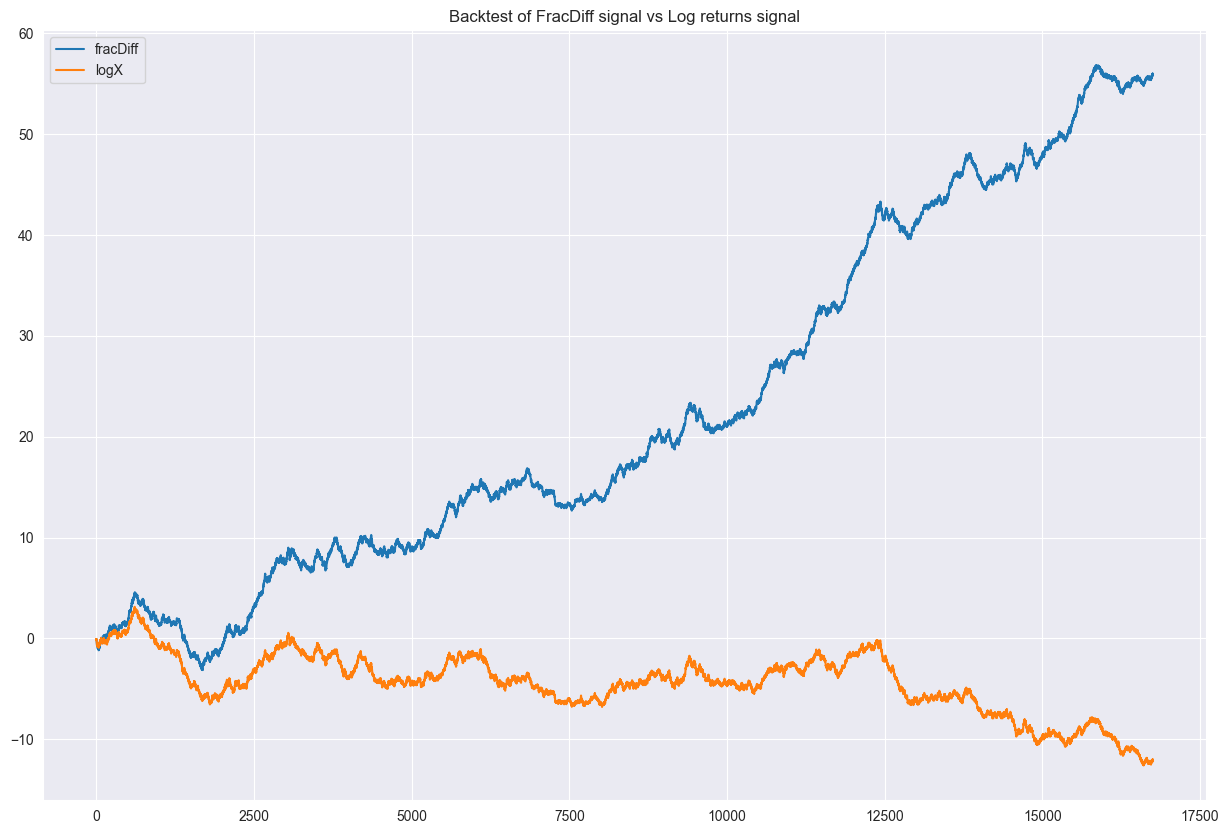

In [73]:
# backtest
logLinReg = model.fit(logX[1:], y[1:]).predict(logX[1:])
logLinReg = np.squeeze(np.sign(logLinReg))
logLinReg = logLinReg[search.best_params_['fracdiff__window']-1:]

def backtest(signal):
    portfolio_returns = signal * close
    cumulative_returns = portfolio_returns.cumsum()
    return cumulative_returns

plt.figure(figsize=(15,10))
plt.plot(backtest(np.squeeze(np.sign(fracDiff))))
plt.plot(backtest(np.squeeze(np.sign(logLinReg))))
plt.title('Backtest of FracDiff signal vs Log returns signal')
plt.legend(['fracDiff', 'logX'])
plt.show()